# Modeling Two Starspots with Known True Values
## The goal of the notebook is to create a model that can tell the user the most probable amplitude, sigma, latitude, and longitude of a starspot through statistical methods. 
### We begin by defining our star spots and visualizing them.

In [1]:
%matplotlib inline
import numpy as np
import exoplanet as xo
import starry
import pymc3 as pm
from corner import corner
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

starry.config.lazy = False
starry.config.quiet = True

C:\Users\becca\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\becca\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In this cell we define what we call our true values for a star with two spots. The amplitude is defined as the "fractional change in the luminosity of the map due to the spot", sigma is the "standard deviation of the gaussian", and latitude and longitude provide the location of the spots. Here we assume that we know the inclination of the star to be 60 degrees. The use of real data may require that the inclination be calculated as it is not always known. 

The animated map shows the star spots and the view of the stellar surface due to the inclination. 


*Definitions from "Star spots" by Rodrigo Luger*

In [2]:
truths = [-0.01, 0.025, 30, 30, -0.02, 0.043, -20, 100, 1]
names = ["amp", "sigma", "lat", "lon", "amp1", "sigma1", "lat1", "lon1", "period"]
inc = 60.0


map = starry.Map(8)   #reduced from 10
map.inc = inc
map.add_spot(amp=truths[0], sigma=truths[1], lat=truths[2], lon=truths[3])
map.add_spot(amp=truths[4], sigma=truths[5], lat=truths[6], lon=truths[7]) 

map.show(theta=np.linspace(0,360,50)) #i wanted it to spin 



The cell below returns a graph of the stellar flux over time. As the starspots rotate into view the total normalized flux is reduced. The pattern repeats every day indicating no change in the size, brightness, or location of the starspot.

C:\Users\becca\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Text(0, 0.5, 'normalized flux')

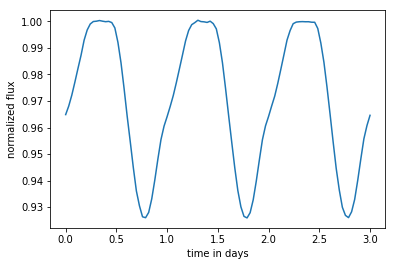

In [3]:
t = np.linspace(0,3,100)    
flux0 = map.flux(theta=360.0/truths[8]*t)
np.random.seed(0)
flux_err = 2e-4
flux = flux0 + flux_err *np.random.randn(len(t))

#plotting
plt.plot(t,flux)
plt.xlabel('time in days')
plt.ylabel('normalized flux')

### In this section we will be creating a model for the MCMC to follow

Here we define a model with all of the parameters needed to model a starspot. 

In [4]:
def model(amp,sigma,lat,lon, amp1, sigma1, lat1, lon1, period):
    map.reset()
    map.inc =  60.0
    map.add_spot(amp=amp, sigma=sigma, lat=lat, lon=lon)
    map.add_spot(amp=amp1, sigma=sigma1, lat=lat1, lon=lon1) #new
    return map.flux(theta=360/period*t)

In [5]:
import emcee

This cell we discuss the likelihood of the data acting as a well behaved gaussian. The equation we use is:
$\ln\mathcal{L} = {-\frac{1}{2}\chi^2}$.




In [6]:
def lnlike(params):
    amplitude, sigma, latitude, longitude, amp1, sigma1, lat1, lon1, period = params   
    chisq = np.sum((model(amplitude, sigma, latitude, longitude, amp1, sigma1, lat1, lon1, period)-flux)**2 / flux_err**2)
    return -0.5*chisq

#note the phase = longitude 

In this cell we provide acceptable ranges for our parameters to fall within. Thes ranges were chosen based on the true values that we assigned at the top of the notebook. The ranges must be narrow enough to ensure that no walkers of our MCMC get lost, but large enough to prevent the walkers from having too little space to roam.

In [7]:
def lnAmplitude(amplitude):    #amplitude
    if amplitude < -0.03 :   #changed from -0.08 to narrow window-prevent random mall walkers
        return -np.inf  
    elif amplitude > 0:    #unsure of what to set amplitude to?
        return -np.inf
    else:
        return 0
    
def lnSigma(sigma):
    if sigma <0.01:
        return -np.inf   
    elif sigma >0.04: #changed from 0.2 to limit walkers to the lower bound  
        return -np.inf
    else:
        return 0
    
def lnLatitude(latitude):
    if latitude < -90:  #do we reallly want to this tho? here we KNOW the latitude but we wont always?
        return -np.inf
    elif latitude > 90:  # phase =longitude    #changed -90 from 0
        return -np.inf
    else:
        return 0
    
def lnLongitude(longitude):
    if longitude <-180:
        return -np.inf     #kept these because the walkers found it no problem.
    elif longitude >180:
        return -np.inf
    else:
        return 0
    
    
    
def lnAmplitude1(amp1):    
    if amp1 < -0.03 :   
        return -np.inf  
    elif amp1 > 0:    
        return -np.inf
    else:
        return 0
    
def lnSigma1(sigma1):
    if sigma1 <0.01:
        return -np.inf   
    elif sigma1 >0.06:   
        return -np.inf
    else:
        return 0
                                 #enforcing an order=breaking degeneracy 
def lnLatitude1(lat1):
    if lat1 < -90:  
        return -np.inf
    elif lat1 > 90:  
        return -np.inf
    else:
        return 0
    
def lnLongitude1(lon1):
    if lon1 <-180:
        return -np.inf     
    elif lon1 >180:
        return -np.inf
    else:
        return 0
    
def lnPeriod(period):
    if period <0.9:
        return -np.inf     
    elif period >1.1:
        return -np.inf
    else:
        return 0

Priors can be defined as the total knowns before data. Because we have converted our likelihood into log to prevent us from working with small numbers we must add the probabilities of our priors being correct in order to comply with logarithm rules. We must remember that probabilities multiply.  

In [8]:
def lnOrderingPrior(latitude,lat1):   #MAKE SURE THESE ARE CONSISTENT INSIDE
    if latitude > lat1:
        return 0
    elif latitude < lat1:
        return -np.inf
    else:
        return 0    #IF THEY ARE THE SAME!!!!!!!! ONLY IF THEYRE EQUAL

In [9]:
def lnprior(params):  
    amplitude, sigma, latitude, longitude, amp1, sigma1, lat1, lon1, period = params 
    return lnAmplitude(amplitude)+lnSigma(sigma)+lnLatitude(latitude)+lnLongitude(longitude)+lnAmplitude1(amp1)+lnSigma1(sigma1)+lnLatitude1(lat1)+lnLongitude1(lon1)+lnPeriod(period)+lnOrderingPrior(latitude,lat1)


    

The total probability is the sum of the natural log of the priors and the natural log of the likelihood.

In [10]:
def lnprob(params):
    return lnprior(params) + lnlike(params)



A general rule of thumb for determining the number of walkers needed to explore parameter space is to take the number of dimensions and double its multiple of two. More parameter space will need more walkers to explore in order to ensure that we are able to find the regions of highest probability.

In [11]:
nwalkers = 50
ndim = 9
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)


In this cell we run a loop over the total range of the walkers for each of the parameters within the acceptable ranges as defines as above. We let the walkers walk randomly in the defined space. 

In [12]:
initial_pos = []  
for x in range(nwalkers):  
    amplitude = np.random.uniform(-0.03, 0)     
    sigma = np.random.uniform(0.01, 0.04)
    latitude = np.random.uniform(0,90)       
    longitude = np.random.uniform(-180,180)  
    amp1= np.random.uniform(-0.03,0)
    sigma1 = np.random.uniform(0.01, 0.06)
    lat1 = np.random.uniform(-90,0)
    lon1 = np.random.uniform(-180,180)
    period = np.random.uniform(0.9,1.1)
    initial_pos.append([amplitude, sigma, latitude, longitude, amp1, sigma1, lat1, lon1, period]) 

In this cell we run the loop above for a set number of steps. Here we have chosen 2000 steps in order to ensure that each walker has enough time to find the region of highest probability and enough time to stay there which will increase the quality of our plotted data.

In [13]:
for sample in sampler.sample(initial_pos, iterations=2000, progress=True):
    pass




100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:07<00:00,  3.34it/s]


Here we ask the code to tell us what percent of the steps those walkers took were acceptable. 

In [14]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.214


Here we learn about the shape of our walker chain. We have forty walkers, two thousand steps, in eight dimensions.

In [15]:
sampler.chain.shape  

(50, 2000, 9)

This cell reminds our code what the true values of our parameters are. Wwe use this to plot a line where those values are in order to visually see if our walkers have found the correct region to be in.

### Data analysis begins

In this cell we plot the results of our walkers as they move through 8 dimensions and explore the area within their allowed ranges. In each of the four plots we will see where the majority of the walkers converged around the region where they believe the true value of our paramters are based on the models we have provided for them above. We can see here that there is a significant burn-in period (the steps it takes for the walkers to get their bearings) and a few random walkers that just never find the correct values.

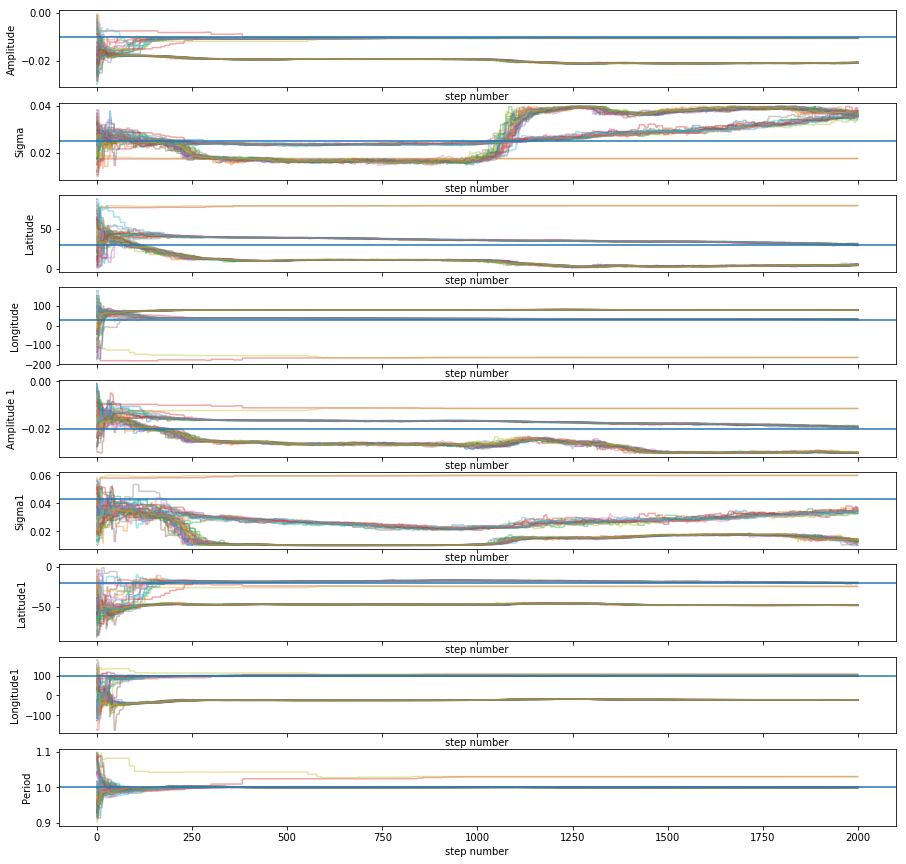

In [16]:
fig, ax = plt.subplots(9,1, sharex=True, figsize=(15,15)) 
walkersample = sampler.chain
yaxisLabels = ["Amplitude", "Sigma", "Latitude", "Longitude","Amplitude 1", "Sigma1", "Latitude1", "Longitude1", "Period"] 
for R in range(ndim):   
    axes = ax[R]
    for Y in range(nwalkers): 
        axes.plot(walkersample[Y,:, R], alpha=0.4) 
    axes.set_ylabel(yaxisLabels[R])
    axes.set_xlabel('step number')
    axes.axhline(truths[R])   
    



### Rerun the chain

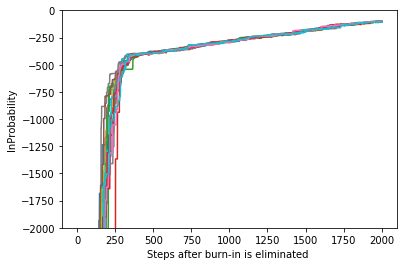

In [17]:
for R in range(nwalkers):
    plt.plot(sampler.lnprobability[R,:])
    plt.xlabel('Steps after burn-in is eliminated ')
    plt.ylabel('lnProbability')
plt.ylim(-2000,0);

In [18]:
print(walkersample.shape)
sampler.lnprobability.shape 
meanprob = np.mean(sampler.lnprobability[:,1500:], axis=1)
goodwalkers = walkersample[meanprob > -2000,1500:]
print(meanprob > -2000)
goodwalkers.shape

(50, 2000, 9)
[ True  True  True False False False  True  True False  True  True False
  True False False False False False  True False False False False  True
 False False False False False False False False False  True False  True
 False  True False  True False False False  True False False  True False
 False  True]


(17, 500, 9)

-0.010388531474177225
0.03654757374936429
30.2828746476023
32.29814485414862
-0.01909968903591875
0.034566673536713624
-19.796223009850934
100.73505298789952
1.000371571829146
2.434037071554835e-05
0.0013415092342822534
0.7536421680273855
0.46206760554315784
0.0003034493988940582
0.0012302961752423494
0.3508137255921866
100.73505298789952
0.00016481258188316865


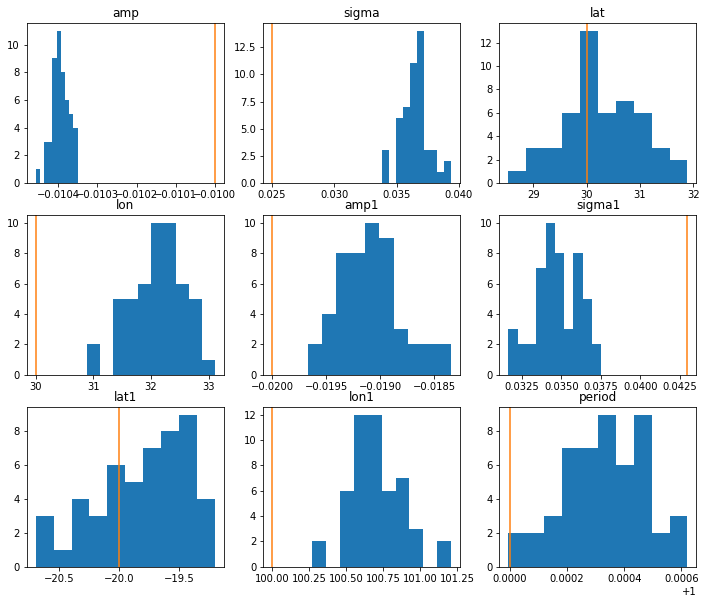

In [19]:
meanamplitude = np.mean(goodwalkers[:,-1,0])
print(meanamplitude)
meansigma = np.mean(goodwalkers[:,-1,1])
print(meansigma)
meanlat = np.mean(goodwalkers[:,-1,2])
print(meanlat)
meanlon = np.mean(goodwalkers[:,-1,3])
print(meanlon)
meanamplitude1 = np.mean(goodwalkers[:,-1,4])
print(meanamplitude1)
meansigma1 = np.mean(goodwalkers[:,-1,5])
print(meansigma1)
meanlat1 = np.mean(goodwalkers[:,-1,6])
print(meanlat1)
meanlon1 = np.mean(goodwalkers[:,-1,7])
print(meanlon1)
meanperiod = np.mean(goodwalkers[:,-1,8])
print(meanperiod)

stdamplitude = np.std(goodwalkers[:,-1,0])
print(stdamplitude)
stdsigma = np.std(goodwalkers[:,-1,1])
print(stdsigma)
stdlat = np.std(goodwalkers[:,-1,2])
print(stdlat)
stdlon = np.std(goodwalkers[:,-1,3])
print(stdlon)
stdamplitude1 = np.std(goodwalkers[:,-1,4])
print(stdamplitude1)
stdsigma1 = np.std(goodwalkers[:,-1,5])
print(stdsigma1)
stdlat1 = np.std(goodwalkers[:,-1,6])
print(stdlat1)
stdlon1 = np.std(goodwalkers[:,-1,7])
print(meanlon1)
stdperiod = np.std(goodwalkers[:,-1,8])
print(stdperiod)


newwalkers = []  
for x in range(nwalkers):  
    amplitude = meanamplitude + stdamplitude *np.random.randn()     
    sigma = meansigma + stdsigma *np.random.randn()
    latitude = meanlat + stdlat *np.random.randn()       
    longitude = meanlon + stdlon *np.random.randn()  
    amp1= meanamplitude1 + stdamplitude1 *np.random.randn()
    sigma1 = meansigma1 + stdsigma1 *np.random.randn()
    lat1 = meanlat1 + stdlat1 *np.random.randn()
    lon1 = meanlon1 + stdlon1 *np.random.randn()
    period = meanperiod + stdperiod *np.random.randn()
    newwalkers.append([amplitude, sigma, latitude, longitude, amp1, sigma1, lat1, lon1, period]) 







fig, ax = plt.subplots(3, 3, figsize=(12, 10))
ax = ax.flatten()
for k in range(9):
    ax[k].hist(np.array(newwalkers)[:, k])
    ax[k].axvline(truths[k], color="C1")
    ax[k].set_title(names[k])


In [69]:
sampler.reset()
for sample in sampler.sample(newwalkers, iterations=3000, progress=True):
    pass

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [19:15<00:00,  2.43it/s]


In [52]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.089


This cell is showing us the chain of walkers after the mean and standard deviation has been calculated for each parameter, allowing us to shift the gaussian. 

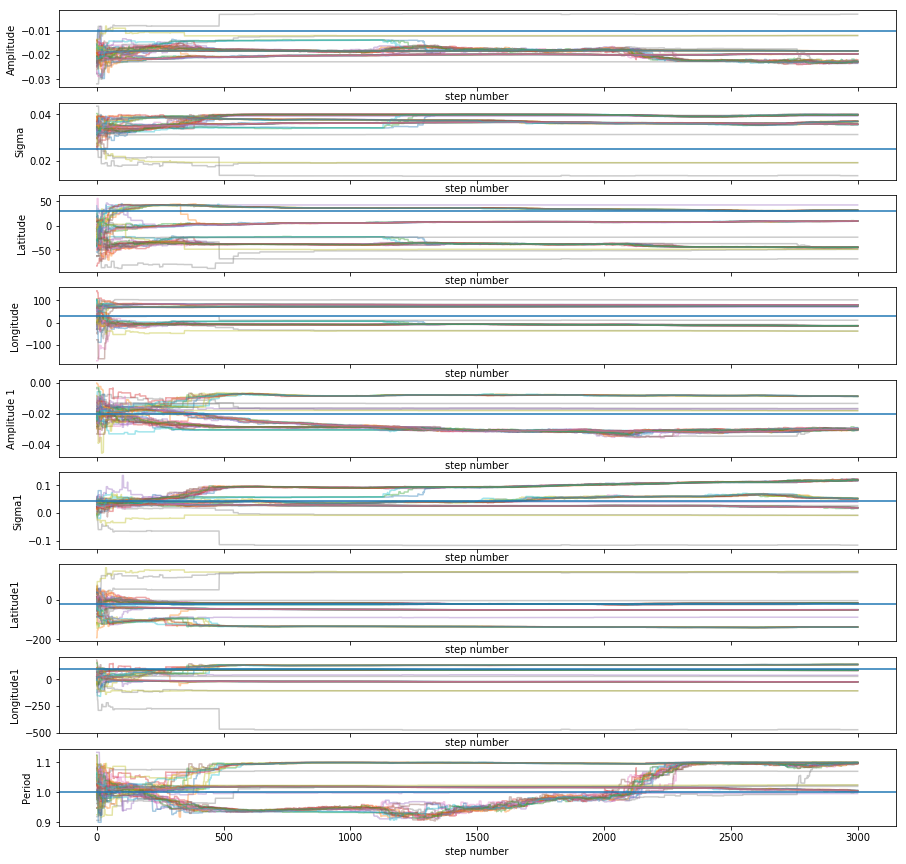

In [71]:
fig, ax = plt.subplots(9,1, sharex=True, figsize=(15,15)) 
walkersample = sampler.chain
yaxisLabels = ["Amplitude", "Sigma", "Latitude", "Longitude","Amplitude 1", "Sigma1", "Latitude1", "Longitude1", "Period"] 
for R in range(ndim):   
    axes = ax[R]
    for Y in range(nwalkers): 
        axes.plot(walkersample[Y,:, R], alpha=0.4) 
    axes.set_ylabel(yaxisLabels[R])
    axes.set_xlabel('step number')
    axes.axhline(truths[R])   
    

This cell is showing us range of probabilities where the walkers are converging. Here we can eliminate the burn in and then set the limits of the y-axis to show us what we want to see. The goal here is to find a way to automate this step. To do this we could either select for the biggest group of converged walkers which would indicate the most likely probability or we can restart the chain but with parameters drawn from a tighter distribution then randomize and restart the walkers from there. 

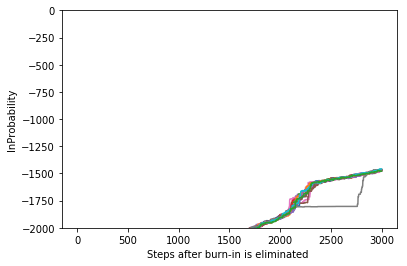

In [80]:
for R in range(nwalkers):
    plt.plot(sampler.lnprobability[R,:])
    plt.xlabel('Steps after burn-in is eliminated ')
    plt.ylabel('lnProbability')

plt.ylim(-2000,0);



#To automate
#Lets find a way for the code to select for the highest number of converged walkers
#set a y-axis limit to just above the 2nd highest convergence #
#then plot....
#how to find the burn in value?


Not a very high maximum probabilty at all

In [79]:
maxprob = np.max(sampler.lnprobability)
maxprob

-1458.385101546416

This cell is doing very important work! Here we ask the code to tell us the number of walkers we assigned, how many steps they took and in how many dimensions. Then we use the plot from above to say that the first 400 steps were just the walkers trying to find their path, so we ignore them. Then we ask the code to tell us which of the walkers averaged steps in the area after the first 400 steps. The true false array tells us which walkers did and did not move around in the region we have deemed to be good. Now we can select the "good walkers" to be those whose average probability is greater than -200 past the first 400 steps. By doing this we see that now we have 25 walkers and 1600 steps remaining. 

In [84]:
print(walkersample.shape)
sampler.lnprobability.shape 
meanprob = np.mean(sampler.lnprobability[:,1000:], axis=1)
goodwalkers = walkersample[meanprob > -3000,1000:]
print(meanprob > -3000)
goodwalkers.shape

(50, 3000, 9)
[False False False  True False  True  True False False False  True False
 False  True  True  True  True False False False  True  True  True  True
 False  True  True False False False False  True False False  True  True
 False  True False  True False False  True False False False False False
 False False]


(20, 2000, 9)

Here we plot the newly determined good walkers on a corner plot. The regions of highest density are the regions of highest probability. The blue lines show us the true values of each parameter. It should be that the highest density regions surround the true value. 

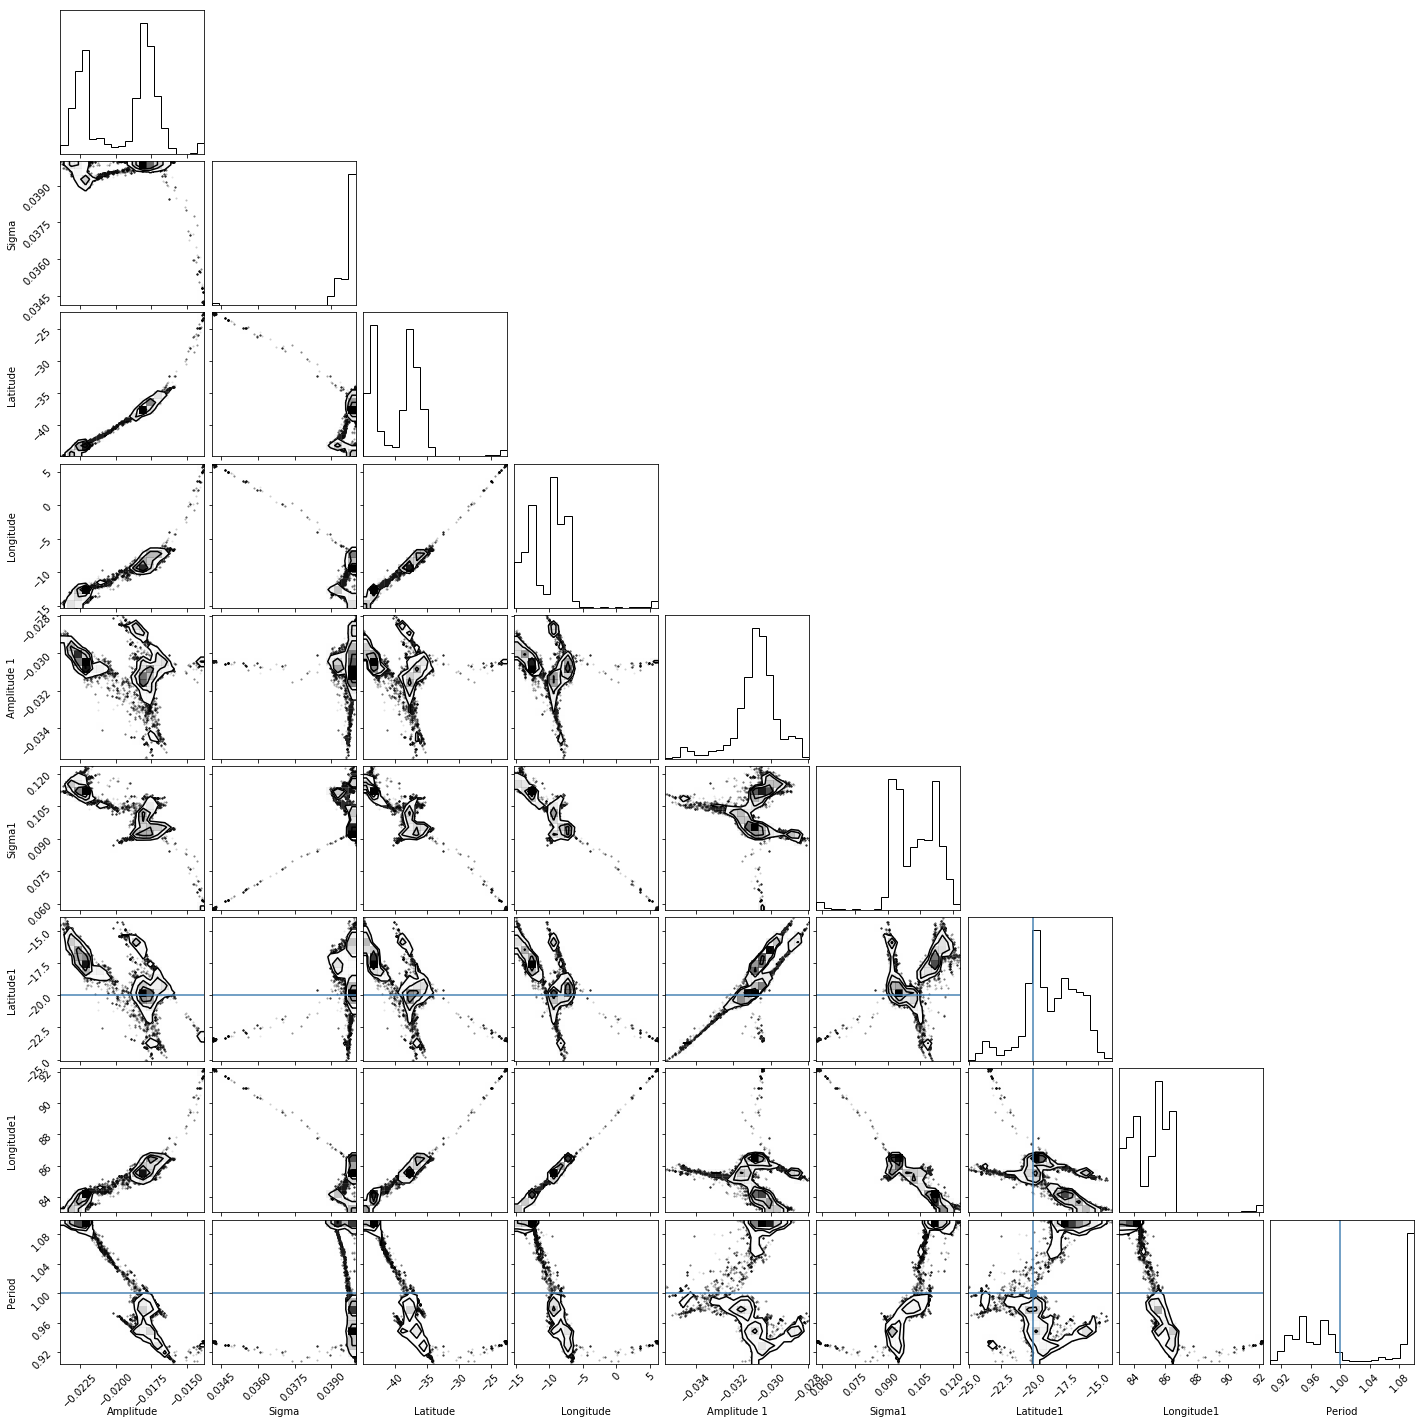

In [85]:
import corner

flat_samples = goodwalkers.reshape(-1,9)  
fig = corner.corner(flat_samples, labels=yaxisLabels,  axvline=True ,plot_contours=True, truths=truths)


Here we are plotting the chain of our good walkers. It can be seen that the walkers who never found the true value region have been eliminated and that the walkers start at convergence. 

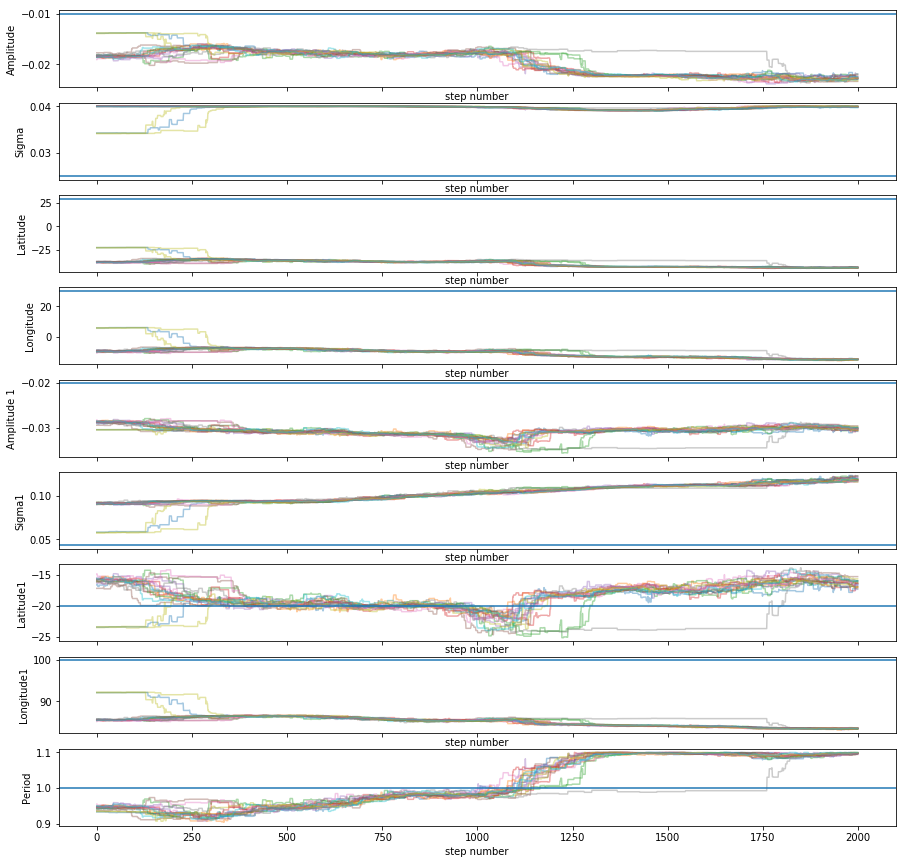

In [86]:
ngoodwalkers = goodwalkers.shape[0]
fig, ax = plt.subplots(9,1, sharex=True, figsize=(15,15)) 
walkersample = sampler.chain
yaxisLabels = ["Amplitude", "Sigma", "Latitude", "Longitude","Amplitude 1", "Sigma1", "Latitude1", "Longitude1", "Period"] 
for R in range(ndim):   
    axes = ax[R]
    for Y in range(ngoodwalkers): 
        axes.plot(goodwalkers[Y,:, R], alpha=0.4) 
    axes.set_ylabel(yaxisLabels[R])
    axes.set_xlabel('step number')
    axes.axhline(truths[R])   #horizontal line at known value
    

In the above corner plot we can see that the sigma values of both star spots are bimodal. How can we make this better? By finding the *best* walkers! To do this we simply look at the chain above, notice that the walkers for both sigma find the true value around the 600th step. So we simply plot the graph from the 600th step instead of the 400th as we did above. We start with 1600 steps but only plot 1000 of them. 

In [89]:
print(goodwalkers.shape)
meanprob = np.mean(sampler.lnprobability[:,250:], axis=1)
goodwalkers = walkersample[meanprob > -3000,250:]
bestwalkers = goodwalkers[:,1000:]
print(bestwalkers.shape)

(0, 2750, 9)
(20, 1750, 9)


The final product! A corner graph showing where the walkers have determined the true values to be. 

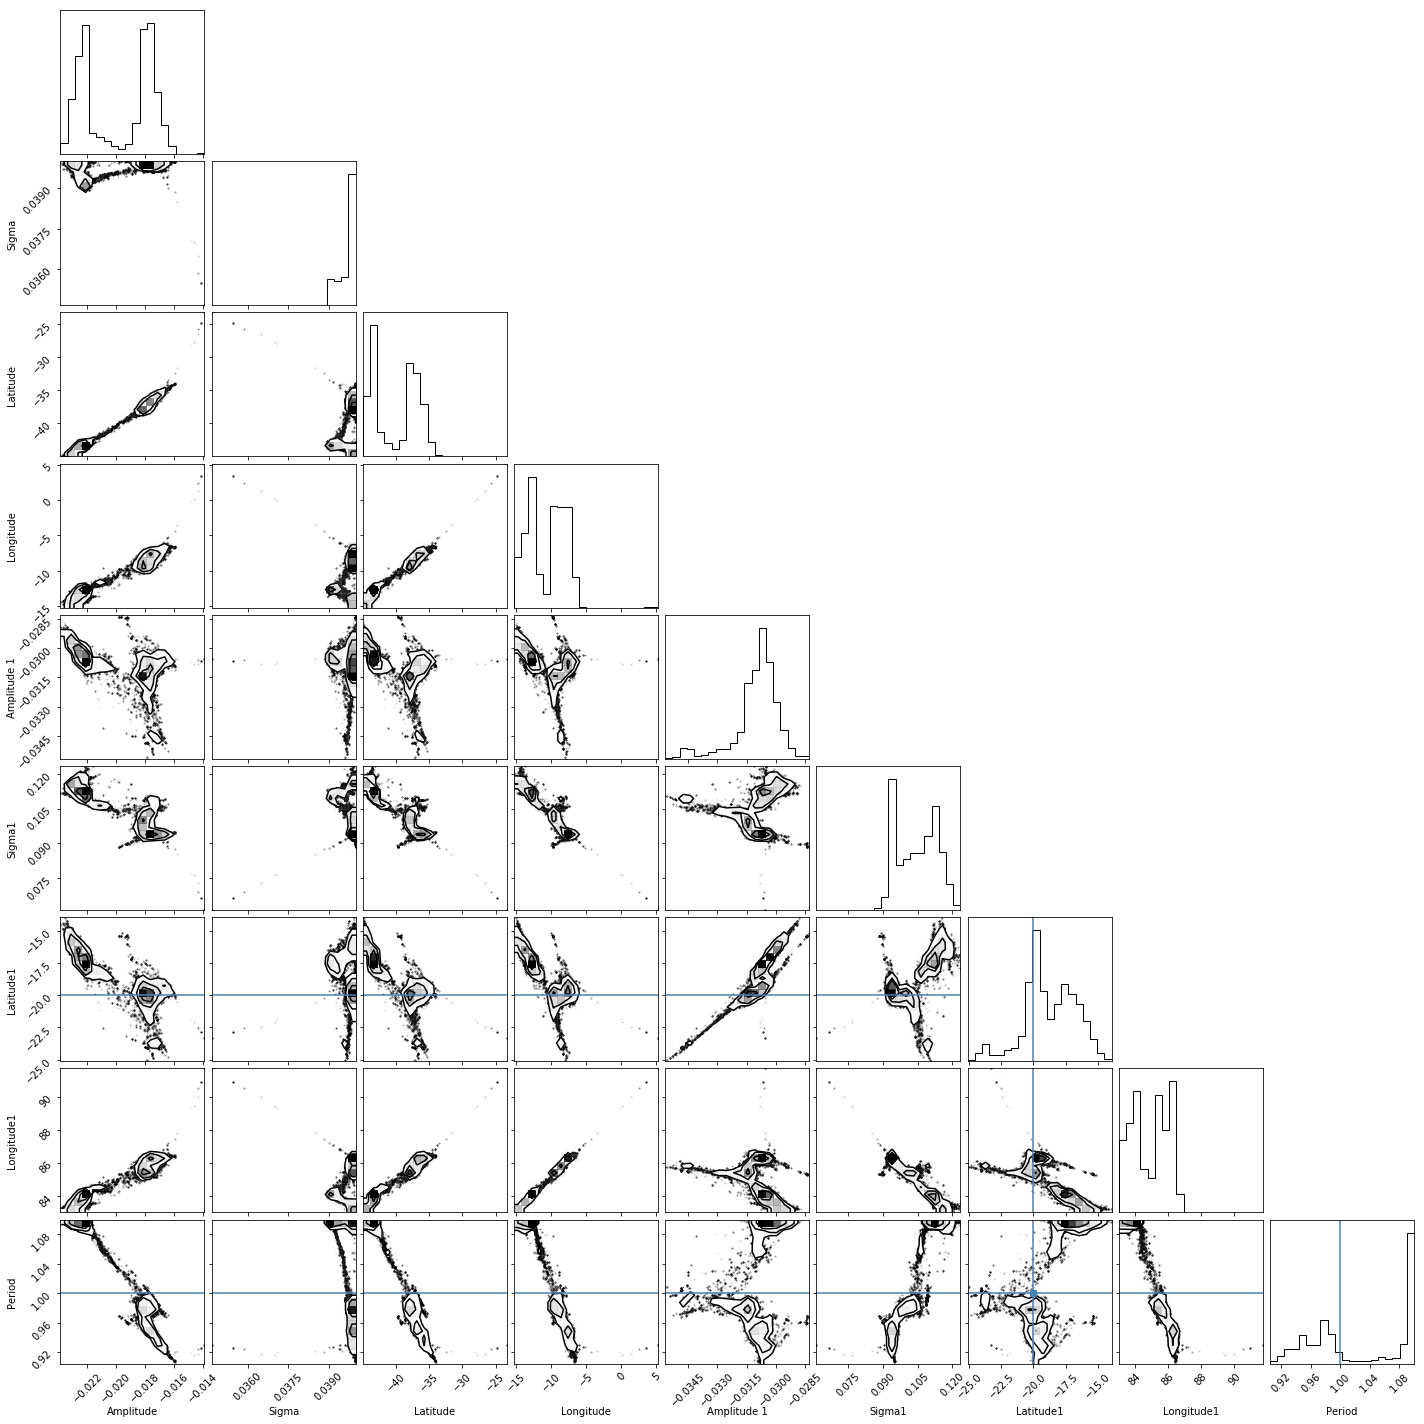

In [90]:
flat_samples = bestwalkers.reshape(-1,9)  
fig = corner.corner(flat_samples, labels=yaxisLabels,  axvline=True ,plot_contours=True, truths=truths)

Plotting the model to the data

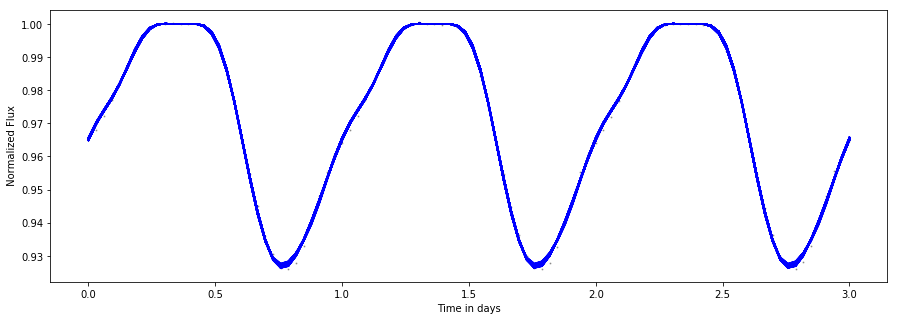

In [91]:
plt.figure(figsize=(15,5))
plt.plot(t, flux, 'k.', ms=2, alpha=0.3)
for i in range(500):
    idx = np.random.randint(len(flat_samples))
    plt.plot(t, model(*flat_samples[idx]), color="blue",alpha=0.3)
plt.xlabel("Time in days")
plt.ylabel(" Normalized Flux");